### Diagnosing Model Performance Under Distribution Shift

- To ensure that we are examining the impact of the Y|X shift(Chapter 4.1.1), we examine the Education variable as follows.
- In the code below, Edu (type: list) represents the values listed in the order of education. We use Preschool to Hs-Grad as the source data and Some-college to Doctorate as the target data.
- In other words, we believe that the salary level (>=50K) has a strong influence on Education, but there are no highly educated people in the Train data, so we have a missing/unobserved covariate.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
pd.set_option('mode.chained_assignment', 'raise') # SettingWithCopyError

# Step 1. Load the Adult dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital Status",
           "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
           "Hours per week", "Country", "Target"]
df = pd.read_csv(url, names=columns, sep=r'\s*,\s*', engine='python', na_values="?")
cont = ["Age","fnlwgt", "Education-Num", "Capital Gain", "Capital Loss", "Hours per week"]


Edu =  ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 
        'Some-college', 'Assoc-voc', 'Assoc-acdm', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']

In [2]:
# Assume we have data from P and Q

df_P =  df[df["Education"].isin(Edu[:9])].reset_index(drop = True)
df_Q =  df[df["Education"].isin(Edu[9:])].reset_index(drop = True)

df_P[cont] = (df_P[cont] - df_P[cont].mean() )/ df_P[cont].std()
df_Q[cont] = (df_Q[cont] - df_Q[cont].mean() )/ df_Q[cont].std()


# Preprocess the data
le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == type(object):
        le.fit(df[column].astype(str))
        df_P.loc[:, column] = le.transform(df_P[column].astype(str))
        df_Q.loc[:, column] = le.transform(df_Q[column].astype(str))
    else:
        pass

    
# Assume we have data from P and Q
X_P = df_P.drop(['Target', "Education"], axis=1).values
y_P = df_P['Target'].values
X_Q = df_Q.drop(['Target', "Education"], axis=1).values
y_Q = df_Q['Target'].values


In [3]:
def detect_shift(X_P, X_Q, y_P, y_Q, print_logloss = True):
    
    # Pre step : Define Models
    model_f = RandomForestClassifier(max_depth=2, random_state=0) #LogisticRegression(solver = 'liblinear') # need check
    pi_estimator = LogisticRegression(solver = 'liblinear') # this model is a better fit for the TREE model.

    # Step 1: Estimation of E_P[R_P(X)] and E_Q[R_Q(X)]
    model_f.fit(X_P, y_P)

    # Compute losses for P and Q
    # We use Log Loss for evaluation!
    E_P_RP = log_loss(y_P, model_f.predict_proba(X_P))
    E_Q_RQ = log_loss(y_Q, model_f.predict_proba(X_Q))
    
    if print_logloss:
        print("===Estimiate log loss===")
        print("E_P_RP: ", E_P_RP)
        print("E_Q_RP: ", E_Q_RQ)
    else:
        pass

    # Step 2: Estimate alpha hat
    n_P = len(y_P)
    n_Q = len(y_Q)
    alpha_hat = n_Q / (n_P + n_Q)

    # Step 3: Estimate pi_hat(x)
    # Compare this paper Stable Learning via Sample Reweighting https://arxiv.org/abs/1911.12580
    X_combined = np.vstack((X_P, X_Q))
    y_combined = np.hstack((np.zeros(len(y_P)), np.ones(len(y_Q))))
    pi_estimator.fit(X_combined, y_combined)

    # Step 4: Calculate importance weights
    pi_P = pi_estimator.predict_proba(X_P)[:, 1]
    pi_Q = pi_estimator.predict_proba(X_Q)[:, 1]
    w_P = pi_P / ((1 - alpha_hat) * pi_P + alpha_hat * (1 - pi_P))
    w_Q = (1 - pi_Q) / ((1 - alpha_hat) * pi_Q + alpha_hat * (1 - pi_Q))
    
    # Step 5: Estimate E_S[R_P(X)] and E_S[R_Q(X)] using these importance weights:
    proba_P = model_f.predict_proba(X_P)
    proba_Q = model_f.predict_proba(X_Q)

    logloss_P = np.array([-np.log(proba_P[i][y_P[i]]) for i in range(len(y_P))])
    logloss_Q = np.array([-np.log(proba_Q[i][y_Q[i]]) for i in range(len(y_Q))])

    E_S_RP = np.sum(w_P * logloss_P) / np.sum(w_P)
    E_S_RQ = np.sum(w_Q * logloss_Q) / np.sum(w_Q)


    # Step 6: Differences between consecutive pairs of estimates
    P_to_S    = E_P_RP - E_S_RP # P to S
    Y_X_Shift = E_S_RP - E_S_RQ # Y|X shfit  
    S_to_Q    = E_S_RQ - E_Q_RQ # S to Q

    
    return P_to_S, Y_X_Shift, S_to_Q

In [4]:
P_to_S, Y_X_Shift, S_to_Q = detect_shift(X_P, X_Q, y_P, y_Q)

===Estimiate log loss===
E_P_RP:  0.3078876081105159
E_Q_RP:  0.6278015827227769


In [5]:
detect_shift(X_P, X_Q, y_P, y_Q)

===Estimiate log loss===
E_P_RP:  0.3078876081105159
E_Q_RP:  0.6278015827227769


(-0.004001945854830047, -0.31422542529796166, -0.0016866034594692492)

In [6]:
def model_run(X_P, X_Q, y_P, y_Q):
    model = RandomForestClassifier(max_depth=2, random_state=0)
    model.fit(X_P, y_P)

    y_P_pred = model.predict(X_P)
    y_Q_pred = model.predict(X_Q)

    accuracy_P = accuracy_score(y_P, y_P_pred)
    accuracy_Q = accuracy_score(y_Q, y_Q_pred)

    #print(f"Accuracy on Source: {accuracy_P}")
    #print(f"Accuracy on Target: {accuracy_Q}")

    accuracy_degradation = accuracy_P - accuracy_Q
    #print(f"Accuracy degradation from Source to Target: {accuracy_degradation}")
    
    return accuracy_P, accuracy_Q




In [7]:
P, Q = model_run(X_P, X_Q, y_P, y_Q)

In [8]:
Y_X_Shift_norm = (Y_X_Shift / (P_to_S + Y_X_Shift + S_to_Q )) * (P - Q)
P_to_S_norm = (P_to_S / (P_to_S + Y_X_Shift + S_to_Q )) * (P - Q)
S_to_Q_norm = (S_to_Q / (P_to_S + Y_X_Shift + S_to_Q )) * (P - Q)

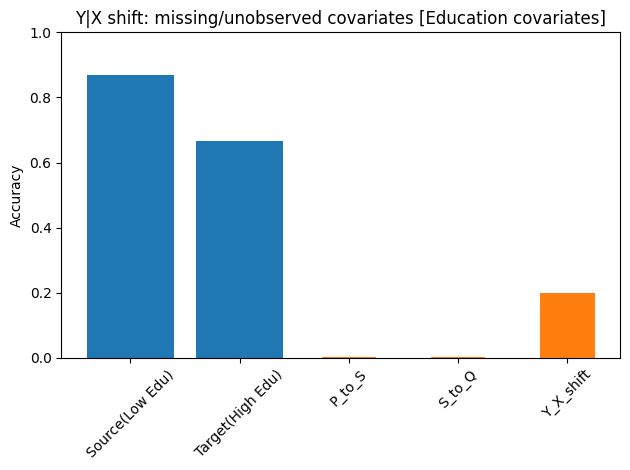

In [9]:
import matplotlib.pyplot as plt

x_values = ['Source(Low Edu)', 'Target(High Edu)', 'difference']
y_values = [P, Q, [P_to_S_norm, S_to_Q_norm, Y_X_Shift_norm]]
difference_labels = ['P_to_S', 'S_to_Q', 'Y_X_shift']

fig, ax = plt.subplots()
ax.bar(x_values[:-1], y_values[:-1], align='center')
ax.bar(difference_labels, y_values[-1], align='center', width=0.5)

ax.set_ylim([0, 1])
plt.xticks(rotation=45)  

plt.title('Y|X shift: missing/unobserved covariates [Education covariates]')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

